Compute the dynamics induced by 3 body coupling Hamiltonian, reproduce plots 
2(d), 5(c), 6(c), 6(f). The Hamiltonian is constructed directly using eq(23).
The computation is faster than that in example 1d but this Hamiltonian only applies 
for the case of driving com mode.  
Ref: https://arxiv.org/abs/2108.01022

In [4]:
#%%
import numpy as np
from qutip import *
import matplotlib.pyplot as plt
import Qsim.operator.spin as spin
import Qsim.operator.spin_phonon as sp_op
import Qsim.ion_chain.ising.ising_c as iscc
from  Qsim.ion_chain.ion_system import *
from scipy import signal
import copy
plt.rcParams['figure.dpi']= 200

In [5]:
#%% set parameters of ion chain
ion_sys = ions(trap_config={'N': 3, 'fx': 5, 'fz': 1.5}, 
                   numeric_config={'active_spin': [0, 1, 2],'active_phonon': [[0]], 'pcut': [[6]]},
                   )
ion_sys.list_para() #print parameters of the system

Trap coefficients updated
Anharmonic coefficients updated
_____________________________________________________________
Checking phonon space setup
Phonon space setups are consistent
_____________________________________________________________
Phonon space parameters updated
Cooling parameters updated
Ions class object initialized.
________________________________________________________________
********************Setup of the Trap************************
number of ions 3
Axial COM (Confining) frequency  1.5  [MHz]
Radial COM (Confining) frequency  5 [MHz]
Axial vibrational eigenfrequency [1.5  2.6  3.61] MHz
Radial (Transverse) vibrational eigenfrequency [5.   4.77 4.43] MHz
                                                                 
********************Config of Numeric Calculation************************
index of phonon space included in simulation:  [[0]]
corresonding phonon space cutoff  [[6]]
********************Config of Cooling************************
Effective cooling 

In [6]:
#%% set parameters of lasers according to the paper
R1 = 26*1e3*2*np.pi #recoil frequency
#compute Dk
Dk1 = np.sqrt(R1*2*MYb171/h) #effective wavenumber
q = 1.3 #compensation scale parameter
delta = 4 #kHz

#symmetric beatnote
#blue sideband 1
laser1 = Laser(config = {'Omega_eff':30,'wavevector':1,'Dk':Dk1,'laser_couple':[0,1,2],
                'mu':2*(delta+1e3*ion_sys.fx),'phase':0})
Omega_r = 16*laser1.eta(ion_sys.fx)
Omega_b = 2*np.sqrt(3)*Omega_r/laser1.eta(ion_sys.fx)
laser1.Omega_eff = Omega_b 
#red sideband
laser2 = copy.copy(laser1)
laser2.Omega_eff = Omega_r 
laser2.mu = -1*(delta+1e3*ion_sys.fx)
#compensation beatnote
#compensation blue sideband
laser3 = copy.copy(laser1)
laser3.Omega_eff = np.sqrt(q)*Omega_b 
laser3.mu = 2*(-q*delta+1e3*ion_sys.fx)
#compensation red sideband
laser4 = copy.copy(laser1)
laser4.Omega_eff = np.sqrt(q)*Omega_r 
laser4.mu = -1*(-q*delta+1e3*ion_sys.fx)
print('________________________________________________')
print('Parameteres of laser 1')
laser1.list_para()
print('________________________________________________')
print('Parameteres of laser 2')
laser2.list_para()
print('________________________________________________')
print('Parameteres of laser 3')
laser3.list_para()
print('________________________________________________')
print('Parameteres of laser 4')
laser4.list_para()
#print(laser1.R/(2*np.pi))
print(laser2.Omega(ion_sys)/(2*np.pi))
N = 3

Laser parameters updated
Lasers class object initialized.
________________________________________________
Parameteres of laser 1
                                                                 
********************Parameters of Laser Drive************************
Vibrational degree of freedom couples to the laser: Transverse (Radial)
index of ions that couple to the laser field:  [0, 1, 2]
Effective rabi frequency  55.43  [kHz]
Effective laser frequency  10008.0  [kHz]
Laser phase phis 0.0
(input in rad but displayed in degs)
________________________________________________
Parameteres of laser 2
                                                                 
********************Parameters of Laser Drive************************
Vibrational degree of freedom couples to the laser: Transverse (Radial)
index of ions that couple to the laser field:  [0, 1, 2]
Effective rabi frequency  1.15  [kHz]
Effective laser frequency  -5004.0  [kHz]
Laser phase phis 0.0
(input in rad but displayed 

In [7]:
#%%Reproduce plot 2(d), only consider com mode
def Tthree(eta0, wr,wb,delta0,q):
    J32 = (1+np.sqrt(1/q))*(eta0**4*wr**2*wb)/(16*delta0**2)
    return np.pi/(6*J32)
eta_com = laser1.eta(ion_sys.fx)/np.sqrt(3)
print('predicted period, [ms]')
print(Tthree(eta_com,laser2.Omega(ion_sys),laser1.Omega(ion_sys),delta*2*np.pi,q))

predicted period, [ms]
19.22507069678327


In [8]:
#%% construct Hamiltonian 
Heff_com, arg_com = iscc.H_com_multi(ion_sys,laser2,laser1,laser4,laser3,q) #construct time-dependent H
#print('number of terms,', len(Heff1))
#construct initial state (down down down)
spin_config = np.array([1,1,1])
psi1 =  sp_op.ini_state(ion_sys,s_state = spin_config, p_state = [[0,0,0]], state_type=1)
elist_com = [tensor(spin.sz(N,0),sp_op.p_I(ion_sys)),
          tensor(spin.sz(N,1),sp_op.p_I(ion_sys)),
          tensor(spin.sz(N,2),sp_op.p_I(ion_sys))]
#solve time dependent SE
times =  np.arange(0,40,1e-3)
print('______________________________________________________________________')
print('solving time-dependent Hamiltonian')
result1 = sesolve(Heff_com,psi1,times,args = arg_com,progress_bar=True,options=Options(nsteps=10000))    

______________________________________________________________________
solving time-dependent Hamiltonian
10.0%. Run time:   0.46s. Est. time left: 00:00:00:04
20.0%. Run time:   0.98s. Est. time left: 00:00:00:03
30.0%. Run time:   1.42s. Est. time left: 00:00:00:03
40.0%. Run time:   1.88s. Est. time left: 00:00:00:02
50.0%. Run time:   2.32s. Est. time left: 00:00:00:02
60.0%. Run time:   2.83s. Est. time left: 00:00:00:01
70.0%. Run time:   3.27s. Est. time left: 00:00:00:01
80.0%. Run time:   3.71s. Est. time left: 00:00:00:00
90.0%. Run time:   4.15s. Est. time left: 00:00:00:00
Total run time:   4.60s


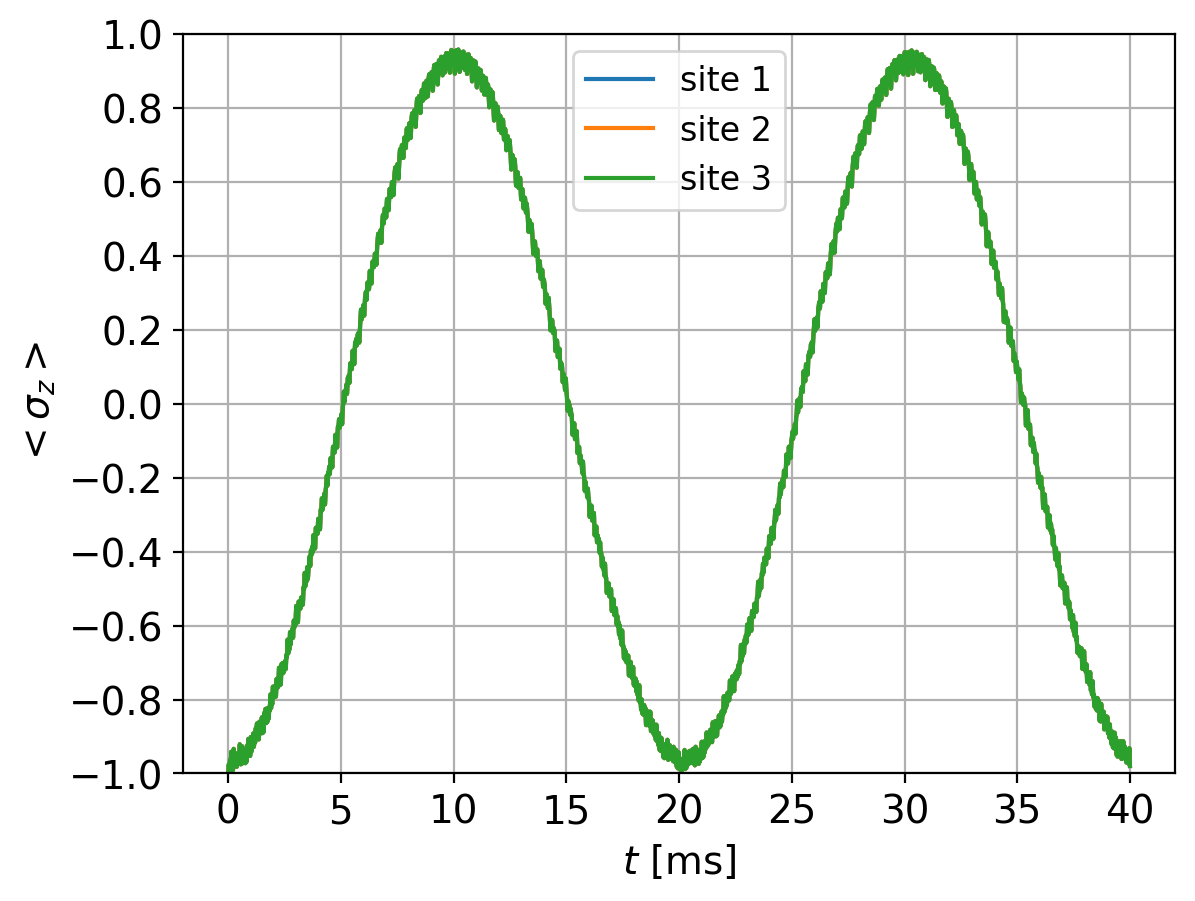

In [9]:
#%%
#plot spin evolution
p1 = expect(elist_com[0],result1.states)
p2 = expect(elist_com[1],result1.states)
p3 = expect(elist_com[2],result1.states)
plt.plot(times,p1,label = 'site 1')
plt.plot(times,p2,label = 'site 2')
plt.plot(times,p3,label = 'site 3')
plt.xlabel(r'$t$ [ms]',fontsize = 14)
plt.ylabel(r'$<\sigma_{z}>$',fontsize = 14)
plt.ylim(-1,1)
plt.yticks(np.arange(-1,1.2,0.2),fontsize = 14)
plt.xticks(fontsize = 14)
plt.legend(fontsize = 12)
plt.grid()
plt.show()

Maximum phonon population of highest com phonon space
0.004520379633925376


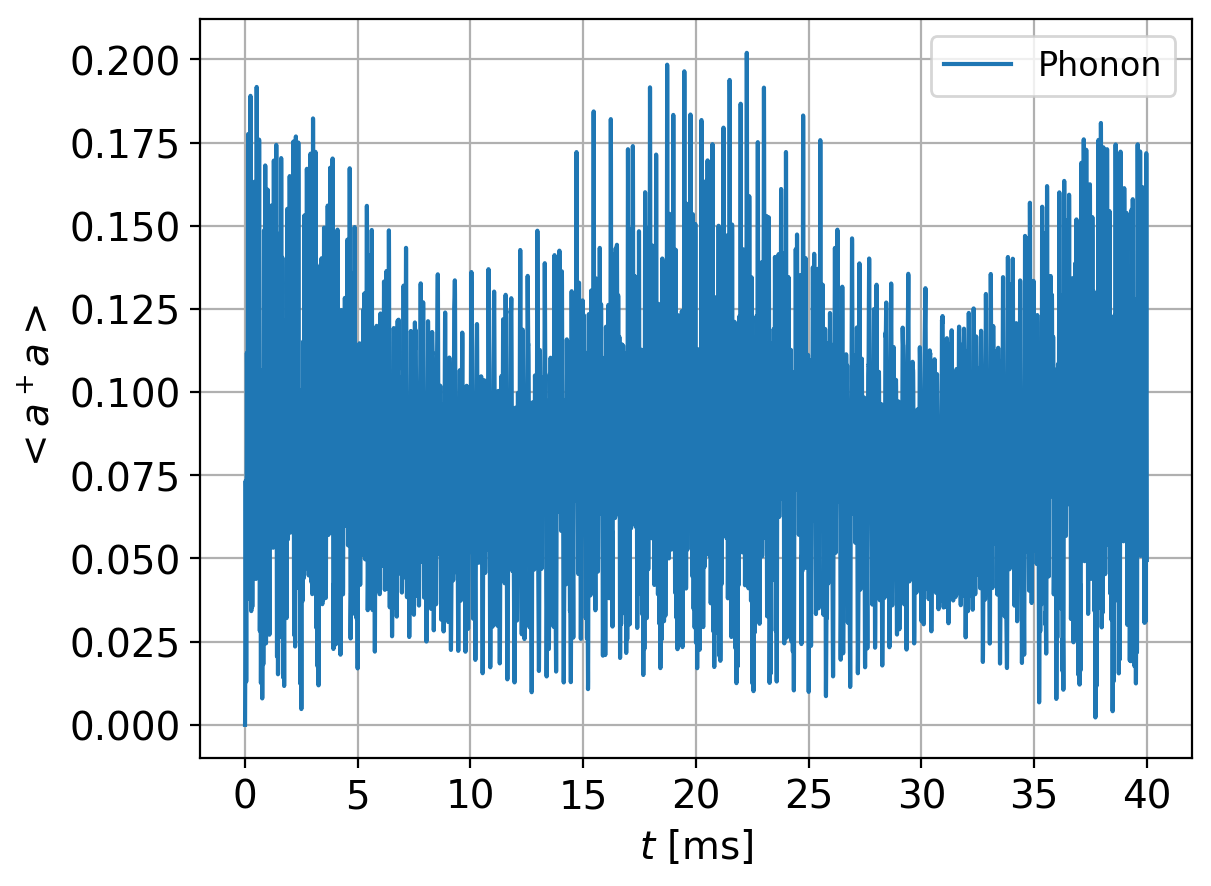

In [10]:
#%%phonon evolution
#note to construct these phonon operators, any laser object above can be applied
mp_state1 = expect(sp_op.pstate_measure(ion_sys,laser1,5,0),result1.states) 
pplot = expect(sp_op.phonon_measure(ion_sys,laser1, mindex=0), result1.states)
print('Maximum phonon population of highest com phonon space')
print(np.max(mp_state1))
plt.plot(times,pplot,label = 'Phonon')
plt.xlabel(r'$t$ [ms]',fontsize = 14)
#title = r'$\delta_{com} = $'+str(ion_sys.delta)+' kHz'
plt.ylabel(r'$<a^+ a>$',fontsize = 14)
#plt.title(title,fontsize = 14)
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)
plt.legend(fontsize = 12)
plt.grid()
plt.show()

In [11]:
#%%simulation with multi-modes, adjust numeric configuration of ion_sys
ion_sys.pcut = [[6,3,3]]
ion_sys.active_phonon = [[0,1,2]]
ion_sys.update_all()
ion_sys.list_para()

Trap coefficients updated
Anharmonic coefficients updated
_____________________________________________________________
Checking phonon space setup
Phonon space setups are consistent
_____________________________________________________________
Phonon space parameters updated
Cooling parameters updated
________________________________________________________________
********************Setup of the Trap************************
number of ions 3
Axial COM (Confining) frequency  1.5  [MHz]
Radial COM (Confining) frequency  5 [MHz]
Axial vibrational eigenfrequency [1.5  2.6  3.61] MHz
Radial (Transverse) vibrational eigenfrequency [5.   4.77 4.43] MHz
                                                                 
********************Config of Numeric Calculation************************
index of phonon space included in simulation:  [[0, 1, 2]]
corresonding phonon space cutoff  [[6, 3, 3]]
********************Config of Cooling************************
Effective cooling rate  [2. 2.]  [kHz

In [12]:
#%% Reproduce 5(c) construct Hamiltonian 
Heff_all, arg_all = iscc.H_com_multi(ion_sys,laser2,laser1,laser4,laser3,q) #construct time-dependent H
#print('number of terms,', len(Heff1))
#construct initial state (down down down)
spin_config = np.array([1,1,1])
psi2 =  sp_op.ini_state(ion_sys,s_state = spin_config, p_state = [[0,0,0]], state_type=1)
elist_all = [tensor(spin.sz(N,0),sp_op.p_I(ion_sys)),
          tensor(spin.sz(N,1),sp_op.p_I(ion_sys)),
          tensor(spin.sz(N,2),sp_op.p_I(ion_sys))]
#solve time dependent SE
print('______________________________________________________________________')
print('solving time-dependent Hamiltonian')
result2 = sesolve(Heff_all,psi2,times,args = arg_all,progress_bar=True,options=Options(nsteps=10000))  

______________________________________________________________________
solving time-dependent Hamiltonian
10.0%. Run time:  16.25s. Est. time left: 00:00:02:26
20.0%. Run time:  32.89s. Est. time left: 00:00:02:11
30.0%. Run time:  50.17s. Est. time left: 00:00:01:57
40.0%. Run time:  66.67s. Est. time left: 00:00:01:40
50.0%. Run time:  83.29s. Est. time left: 00:00:01:23
60.0%. Run time:  99.89s. Est. time left: 00:00:01:06
70.0%. Run time: 116.72s. Est. time left: 00:00:00:50
80.0%. Run time: 133.85s. Est. time left: 00:00:00:33
90.0%. Run time: 150.39s. Est. time left: 00:00:00:16
Total run time: 167.17s


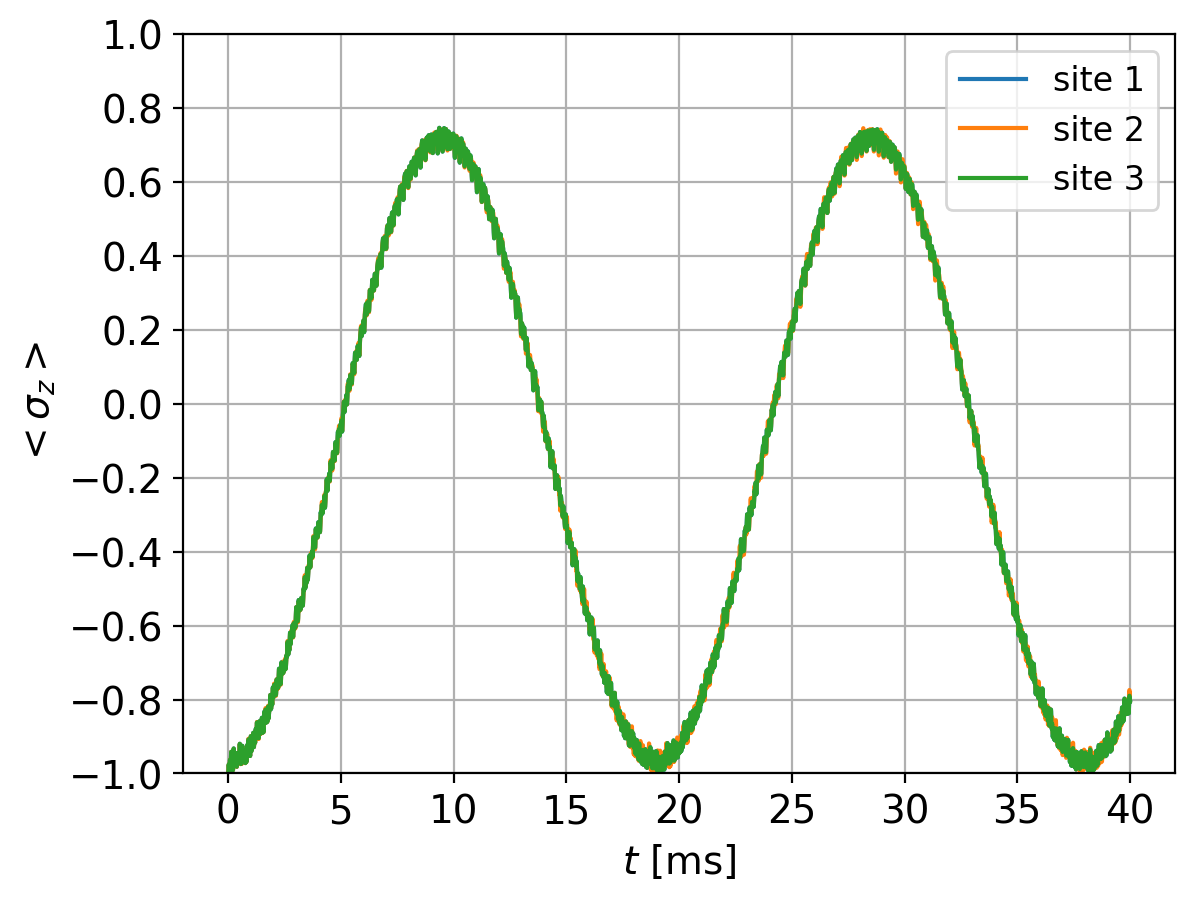

In [13]:
#%%
#plot spin evolution
p1 = expect(elist_all[0],result2.states)
p2 = expect(elist_all[1],result2.states)
p3 = expect(elist_all[2],result2.states)
plt.plot(times,p1,label = 'site 1')
plt.plot(times,p2,label = 'site 2')
plt.plot(times,p3,label = 'site 3')
plt.xlabel(r'$t$ [ms]',fontsize = 14)
plt.ylabel(r'$<\sigma_{z}>$',fontsize = 14)
plt.ylim(-1,1)
plt.yticks(np.arange(-1,1.2,0.2),fontsize = 14)
plt.xticks(fontsize = 14)
plt.legend(fontsize = 12)
plt.grid()
plt.show()

In [14]:
#%% Reproduce 6(c) 
#construct initial state (down up down)
spin_config = np.array([1,0,1])
psi3 =  sp_op.ini_state(ion_sys,s_state = spin_config, p_state = [[0,0,0]], state_type=1)
#solve time dependent SE
print('______________________________________________________________________')
print('solving time-dependent Hamiltonian')
result3 = sesolve(Heff_all,psi3,times,args = arg_all,progress_bar=True,options=Options(nsteps=10000))  

______________________________________________________________________
solving time-dependent Hamiltonian
10.0%. Run time:  15.50s. Est. time left: 00:00:02:19
20.0%. Run time:  31.07s. Est. time left: 00:00:02:04
30.0%. Run time:  46.85s. Est. time left: 00:00:01:49
40.0%. Run time:  62.55s. Est. time left: 00:00:01:33
50.0%. Run time:  78.33s. Est. time left: 00:00:01:18
60.0%. Run time:  93.83s. Est. time left: 00:00:01:02
70.0%. Run time: 109.15s. Est. time left: 00:00:00:46
80.0%. Run time: 124.27s. Est. time left: 00:00:00:31
90.0%. Run time: 139.22s. Est. time left: 00:00:00:15
Total run time: 153.94s


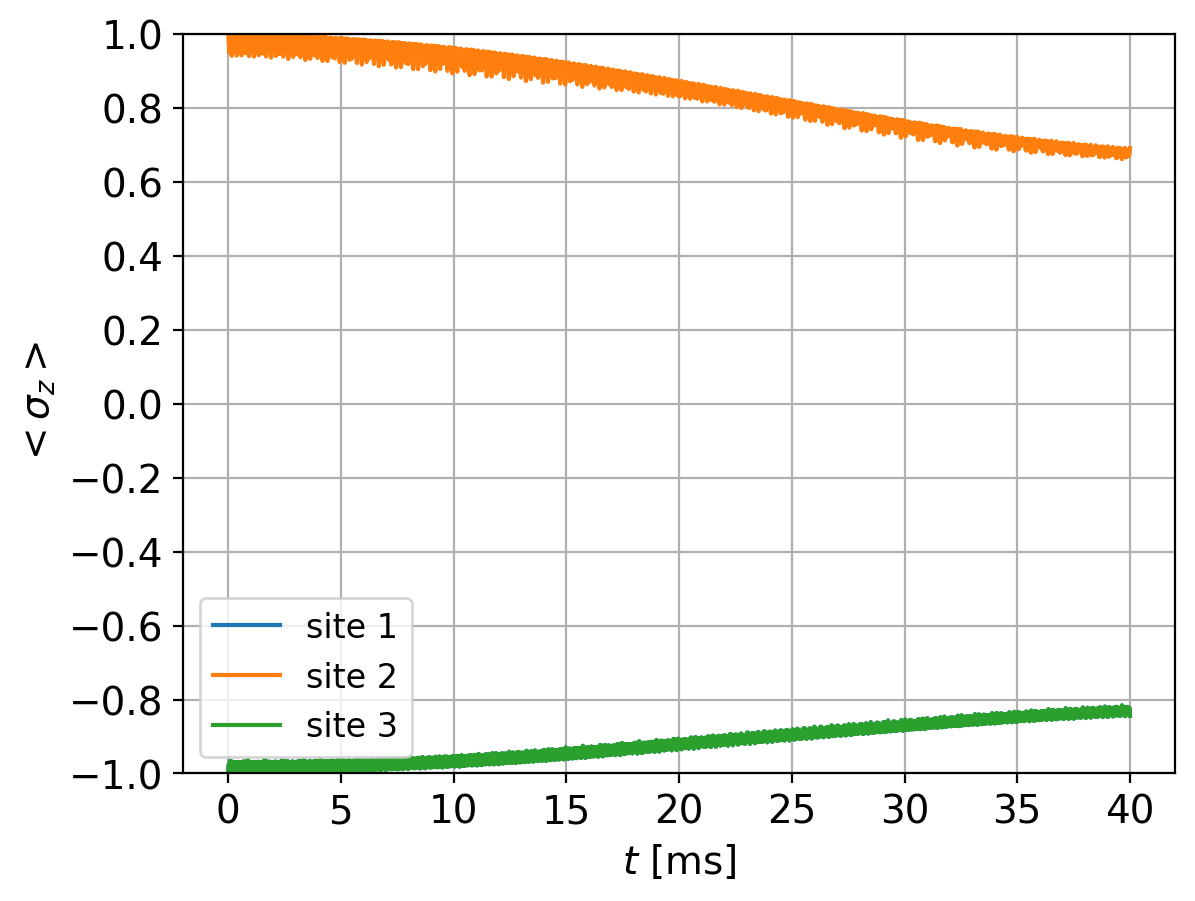

In [15]:
#%%
#plot spin evolution
p1 = expect(elist_all[0],result3.states)
p2 = expect(elist_all[1],result3.states)
p3 = expect(elist_all[2],result3.states)
plt.plot(times,p1,label = 'site 1')
plt.plot(times,p2,label = 'site 2')
plt.plot(times,p3,label = 'site 3')
plt.xlabel(r'$t$ [ms]',fontsize = 14)
plt.ylabel(r'$<\sigma_{z}>$',fontsize = 14)
plt.ylim(-1,1)
plt.yticks(np.arange(-1,1.2,0.2),fontsize = 14)
plt.xticks(fontsize = 14)
plt.legend(fontsize = 12)
plt.grid()
plt.show()

In [16]:
#%% Reproduce 6(f) 
#construct initial state (down down up)
spin_config = np.array([1,1,0])
psi4 =  sp_op.ini_state(ion_sys,s_state = spin_config, p_state = [[0,0,0]], state_type=1)
#solve time dependent SE
print('______________________________________________________________________')
print('solving time-dependent Hamiltonian')
result4 = sesolve(Heff_all,psi4,times,args = arg_all,progress_bar=True,options=Options(nsteps=10000))   

______________________________________________________________________
solving time-dependent Hamiltonian
10.0%. Run time:  16.37s. Est. time left: 00:00:02:27
20.0%. Run time:  32.78s. Est. time left: 00:00:02:11
30.0%. Run time:  49.49s. Est. time left: 00:00:01:55
40.0%. Run time:  66.52s. Est. time left: 00:00:01:39
50.0%. Run time:  83.40s. Est. time left: 00:00:01:23
60.0%. Run time: 100.35s. Est. time left: 00:00:01:06
70.0%. Run time: 117.50s. Est. time left: 00:00:00:50
80.0%. Run time: 134.43s. Est. time left: 00:00:00:33
90.0%. Run time: 151.33s. Est. time left: 00:00:00:16
Total run time: 168.22s


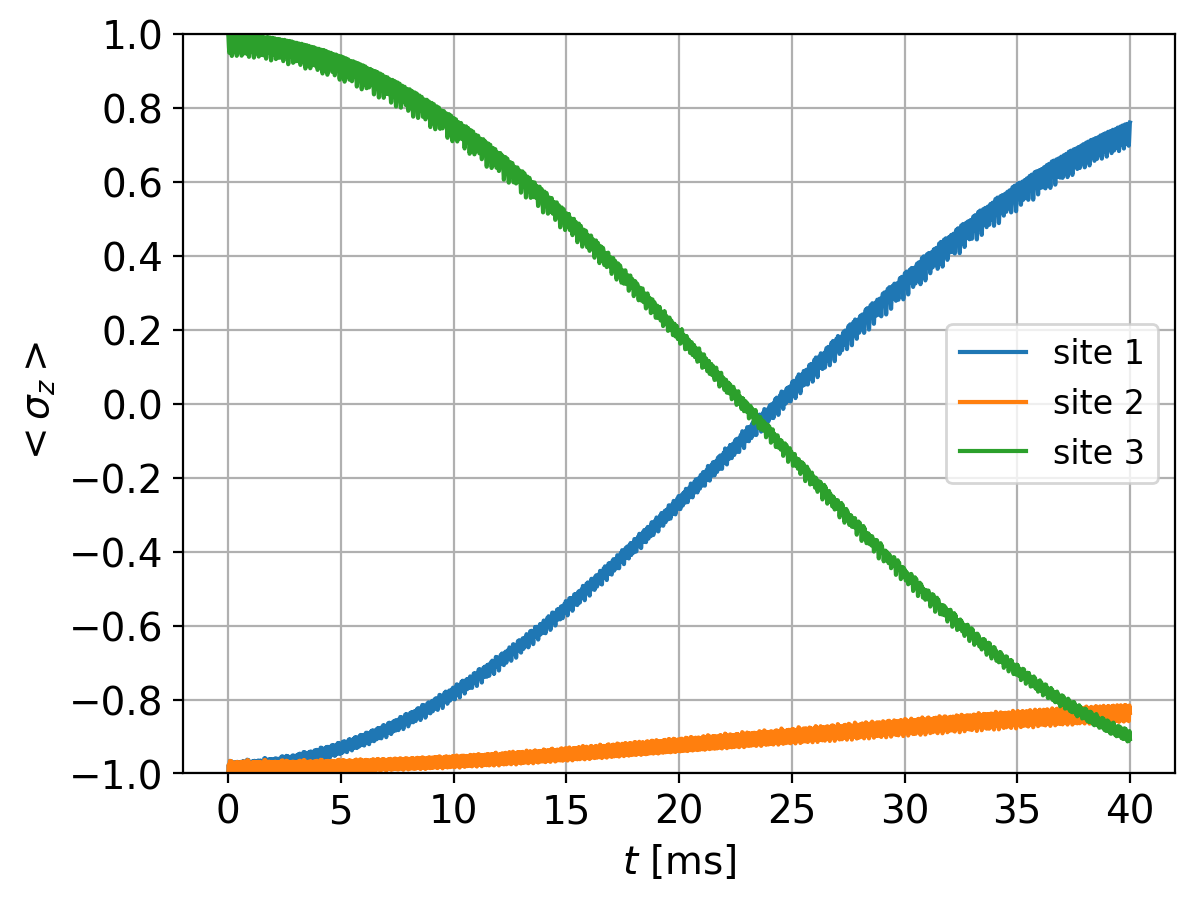

In [17]:
#%%
#plot spin evolution
p1 = expect(elist_all[0],result4.states)
p2 = expect(elist_all[1],result4.states)
p3 = expect(elist_all[2],result4.states)
plt.plot(times,p1,label = 'site 1')
plt.plot(times,p2,label = 'site 2')
plt.plot(times,p3,label = 'site 3')
plt.xlabel(r'$t$ [ms]',fontsize = 14)
plt.ylabel(r'$<\sigma_{z}>$',fontsize = 14)
plt.ylim(-1,1)
plt.yticks(np.arange(-1,1.2,0.2),fontsize = 14)
plt.xticks(fontsize = 14)
plt.legend(fontsize = 12)
plt.grid()
plt.show()